<a href="https://colab.research.google.com/github/nicoerdmann/Termofluidos/blob/main/Tarea_1_Nico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero comenzamos instalando las librerías.

In [ ]:
pip install Coolprop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.7 MB/s eta 0:00:00


In [ ]:
pip install fluids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.1 MB/s eta 0:00:00


In [ ]:
pip install pint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
from scipy import constants
from scipy.constants import g
from fluids.units import *
import pint
import matplotlib.pyplot as plt

#Problema #2

In [ ]:
u = pint.UnitRegistry()

#Importante definir las unidades de medida
Diametro = (1.25 / 39.37) * u.m
vel_promedio = 100 / 3.281 * (u.m/u.s)
Largo = 300 * u.m
Area_transversal = (np.pi*Diametro**2)/4
V_dot = vel_promedio * Area_transversal

#Coolprop no permite trabajar con unidades, estos los dejamos como magnitudes escalares
Temperatura = 20 + 273.15
P_0 = 1 * 6895 + 101325 #Debemos sumar la presión atmosférica
Diametro, vel_promedio, Largo, Area_transversal, V_dot, Temperatura, P_0

(<Quantity(0.0317500635, 'meter')>,
 <Quantity(30.4785126, 'meter / second')>,
 <Quantity(300, 'meter')>,
 <Quantity(0.000791733603, 'meter ** 2')>,
 <Quantity(0.0241308626, 'meter ** 3 / second')>,
 293.15,
 108220)

a) Comenzamos calculando la pérdida de carga de la tubería

In [ ]:
# Definir el fluido como gas natural y la tuberia de cobre
fluido = 'Methane'
material = 'copper'

#Obtenemos la rugosidad del material, la densidad (rho) y el mu
epsilon = fld.material_roughness(material)*u.m
rho = cp.PropsSI('D','T', Temperatura, 'P',P_0, fluido)*u.kg/u.m**3
mu = cp.PropsSI('V','T', Temperatura, 'P',P_0, fluido)*u.Pa*u.s


Determinamos el numero de Reynolds:

In [ ]:
Re = (fld.Reynolds(Diametro, rho, vel_promedio, mu)).to('dimensionless') #Reynolds es un numero adimensional
Re

<Quantity(62571.5769, 'dimensionless')>

Determinamos el factor de fricción:

In [ ]:
f = fld.friction.friction_factor(Re, eD=epsilon/Diametro, Method='Colebrook')
f

<Quantity(0.0588214718, 'dimensionless')>

La pérdida de carga debido a la fricción puede calcularse a través de la siguiente fórmula,

$\Delta P_{\text{friction}} =f \frac{L}{D} \frac{\rho V^{2}}{2}$

In [ ]:
DELTA_P_incompresible = ((f * Largo * rho * vel_promedio**2)/(2 * Diametro)).to(u.kPa)
DELTA_P_incompresible

<Quantity(184.24534, 'kilopascal')>

b) Primero, para entender el grado de error introducido por el supuesto, debemos ver cuáles serán nuestras pérdidas de cargas considerando un fluido compresible, es decir, que cambia su densidad.
Para eso, haremos divisiones a lo largo de la tubería e iremos evaluando las perdidas de carga utilizando las densidades en cada punto.

In [ ]:
P_0 = (1 * 6895 + 101325) * u.Pa
#divisiones de la tuberia
numero_segmentos = 50
longitud_segmento = Largo / numero_segmentos

#perdida de presion acumulada
DELTA_P_compresible = 0

# Sumando los segmentos
for i in range(numero_segmentos):

    Re = (fld.Reynolds(Diametro.magnitude, rho.magnitude, vel_promedio.magnitude, mu.magnitude))
    f = fld.friction.friction_factor(Re, eD=(epsilon.magnitude/Diametro.magnitude), Method='Colebrook')

    # Calcular la pérdida de presión en el segmento actual
    DP_segmento = (f * longitud_segmento * rho * vel_promedio**2) / (2 * Diametro)
    DELTA_P_compresible += DP_segmento

    # Actualizar la presión y propiedades del fluido
    P_actual = P_0 - DELTA_P_compresible
    rho = cp.PropsSI('D', 'T', Temperatura, 'P', P_actual.magnitude, fluido) * u.kg/u.m**3
    mu = cp.PropsSI('V', 'T', Temperatura, 'P', P_actual.magnitude, fluido) * u.Pa*u.s

DELTA_P_compresible = DELTA_P_compresible.to(u.kPa)
print(f"Pérdida total de presión: {DELTA_P_compresible:.2f}")

Pérdida total de presión: 89.48 kilopascal


Para hacer el cálculo del error, podemos utilizar la formula de error:

$Error = \frac{\Delta P_{incompresible}-\Delta P_{compresible}}{\Delta P_{compresible}} * 100$

In [ ]:
error = abs((DELTA_P_incompresible - DELTA_P_compresible))/(DELTA_P_compresible) * 100
error

<Quantity(105.91463, 'dimensionless')>

c) Considerando que el error es significativo, la validez del supuesto de incompresibilidad es errónea.

d) Para este inciso, debo realizar una evaluación del error a lo largo de la tubería. Muy similar al procedimiento anterior:

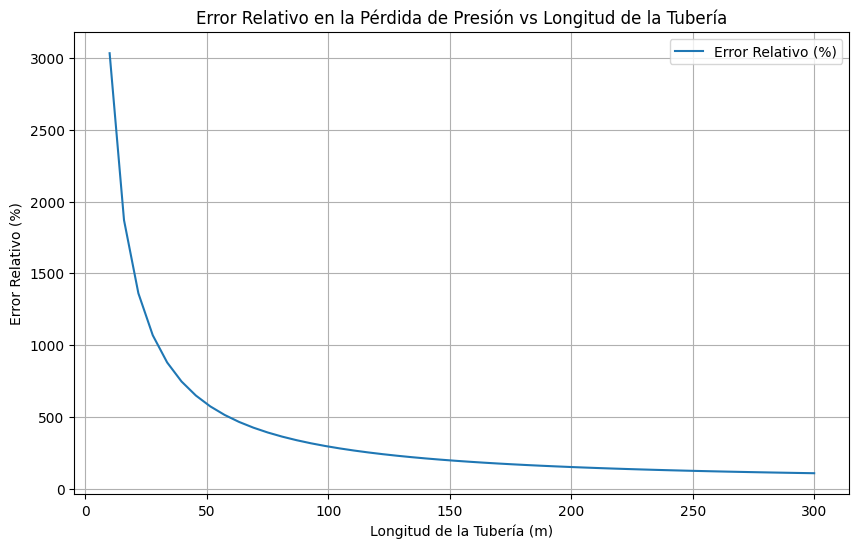

In [ ]:
longitudes = np.linspace(10, Largo.magnitude, 50) * u.m  # Variar la longitud de 10 m a 300 m
error_relativo = []

for Largo in longitudes:
  P_0 = (1 * 6895 + 101325) * u.Pa
  #divisiones de la tuberia
  numero_segmentos = 50
  longitud_segmento = Largo / numero_segmentos

  #perdida de presion acumulada
  DELTA_P_compresible = 0

  # Sumando los segmentos
  for i in range(numero_segmentos):

      Re = (fld.Reynolds(Diametro.magnitude, rho.magnitude, vel_promedio.magnitude, mu.magnitude))
      f = fld.friction.friction_factor(Re, eD=(epsilon.magnitude/Diametro.magnitude), Method='Colebrook')

      # Calcular la pérdida de presión en el segmento actual
      DP_segmento = (f * longitud_segmento * rho * vel_promedio**2) / (2 * Diametro)
      DELTA_P_compresible += DP_segmento

      # Actualizar la presión y propiedades del fluido
      P_actual = P_0 - DELTA_P_compresible
      rho = cp.PropsSI('D', 'T', Temperatura, 'P', P_actual.magnitude, fluido) * u.kg/u.m**3
      mu = cp.PropsSI('V', 'T', Temperatura, 'P', P_actual.magnitude, fluido) * u.Pa*u.s

  DELTA_P_compresible = DELTA_P_compresible.to(u.kPa)
  error = abs((DELTA_P_incompresible - DELTA_P_compresible))/(DELTA_P_compresible) * 100
  error_relativo.append(error)

plt.figure(figsize=(10, 6))
plt.plot(longitudes.magnitude, error_relativo, label='Error Relativo (%)')
plt.xlabel('Longitud de la Tubería (m)')
plt.ylabel('Error Relativo (%)')
plt.title('Error Relativo en la Pérdida de Presión vs Longitud de la Tubería')
plt.grid(True)
plt.legend()
plt.show()